# 1. Load the libraries

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import cv2
import glob
import gc  # Garbage collection to manage memory
import numpy as np
import random
import pandas as pd  
from PIL import Image
from skimage import measure
from keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patches as patches
import tensorflow as tf
from skimage.measure import label, regionprops, regionprops_table
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, MaxPooling2D, AveragePooling2D
from tensorflow import keras 
from sklearn.utils import class_weight
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers, regularizers
from keras.layers import Dropout
from numba import jit
import multiprocessing as mp
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import Sequence


2024-11-24 10:07:08.646243: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-24 10:07:09.594180: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [32]:
#Get wells with middle 3 concentrations 
'''
annotation_data = pd.read_excel("merged_file.xlsx")

# Step 1: Filter out unwanted compounds
controls = ["cells", "BzCl", "DMSO"]
annotation_data_filtered = annotation_data[~annotation_data['Compound'].isin(controls)]
# Step 2: Sort by 'Compound' and 'Concentration'
annotation_data_sorted = annotation_data_filtered.sort_values(by=['Compound', 'Concentration'])

# Step 3: Group by 'Compound' and get the middle 3 concentrations
middle_concentrations = annotation_data_sorted.groupby('Compound').apply(lambda x: x.iloc[1:4]).reset_index(drop=True)

# To get cancer cell count appended in middle_concentrations datframe
cancer_count = pd.read_excel("Cancer_Count.xlsx")
# Step 1: Filter Cancer_Count for 'MH' and 'BjhTERT' in the Combination column
cancer_count_filtered = cancer_count[cancer_count['Combination'].isin(['MH & BjhTERT'])]

# Step 2: Extract Plate number from the second character of 'Set' in Cancer_Count
cancer_count_filtered['Plate'] = cancer_count_filtered['Set'].str[1]

# Step 3: Convert 'Plate' columns to string for proper merging
cancer_count_filtered['Plate'] = cancer_count_filtered['Plate'].astype(str)
middle_concentrations['Plate'] = middle_concentrations['Plate'].astype(str)

# Step 4: Merge on 'Plate' and 'Well_number' to add Cancer_Cell_Count to middle_concentrations
merged_df = pd.merge(
    middle_concentrations,
    cancer_count_filtered[['Plate', 'Well_number', 'Row', 'Column', 'Cancer_Cell_Count']],
    on=['Plate', 'Well_number'],
    how='left'
)

#Filter data to have only 10 MOAs and Cancer cell count in a particular range. 
training_data = merged_df[(merged_df['Category'] != 'Miscl.') & (merged_df['Cancer_Cell_Count'] > 1800) & (merged_df['Cancer_Cell_Count'] < 2800)]
training_data = training_data.sort_values(by='Plate')
print("Length of dataset to be used for building model", len(training_data))
'''

#get middle 3 concnetrations along with DMSO wells 
# Load annotation data
annotation_data = pd.read_excel("merged_file.xlsx")

# Step 1: Filter out unwanted compounds
controls = ["cells", "BzCl"]
annotation_data_filtered = annotation_data[~annotation_data['Compound'].isin(controls)]

# Step 2: Sort the filtered data by 'Compound' and 'Concentration'
annotation_data_sorted = annotation_data_filtered.sort_values(by=['Compound', 'Concentration'])

# Step 3: Get middle 3 concentrations for each compound (excluding DMSO)
middle_concentrations = annotation_data_sorted.groupby('Compound').apply(lambda x: x.iloc[1:4]).reset_index(drop=True)

# Step 4: Extract all DMSO wells
dmso_wells = annotation_data_sorted[annotation_data_sorted['Compound'] == 'DMSO']

# Combine middle concentrations with all DMSO wells
combined_concentrations = pd.concat([middle_concentrations, dmso_wells], ignore_index=True)

# Load cancer cell count data
cancer_count = pd.read_excel("Cancer_Count.xlsx")

# Step 5: Filter Cancer_Count for specific combinations
cancer_count_filtered = cancer_count[cancer_count['Combination'].isin(['MH & BjhTERT'])]

# Step 6: Extract Plate information from the 'Set' column and ensure Plate is string
cancer_count_filtered['Plate'] = cancer_count_filtered['Set'].str[1].astype(str)
combined_concentrations['Plate'] = combined_concentrations['Plate'].astype(str)

# Step 7: Merge cancer cell count data with combined concentrations on 'Plate' and 'Well_number'
merged_df = pd.merge(
    combined_concentrations,
    cancer_count_filtered[['Plate', 'Well_number', 'Row', 'Column', 'Cancer_Cell_Count']],
    on=['Plate', 'Well_number'],
    how='left'
)

# Step 8: Filter data to include:
# - All DMSO wells
# - Other compounds with Cancer_Cell_Count in a specific range and not in 'Miscl.' category
training_data = merged_df[
    ((merged_df['Compound'] == 'DMSO') |  # Include all DMSO wells
    ((merged_df['Category'] != 'Miscl.') &  # Exclude 'Miscl.' category
     (merged_df['Cancer_Cell_Count'] > 1800) &  # Cancer cell count greater than 1800
     (merged_df['Cancer_Cell_Count'] < 2800)))  # Cancer cell count less than 2800
]

# Sort training data by 'Plate' for better organization
training_data = training_data.sort_values(by='Plate')

# Display the length of the resulting dataset
print("Length of dataset to be used for building model:", len(training_data))

# Perform garbage collection to free memory
gc.collect()

/tmp/ipykernel_2299144/2757003285.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  middle_concentrations = annotation_data_sorted.groupby('Compound').apply(lambda x: x.iloc[1:4]).reset_index(drop=True)
/tmp/ipykernel_2299144/2757003285.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_count_filtered['Plate'] = cancer_count_filtered['Set'].str[1].astype(str)


Length of dataset to be used for building model: 340


15970

In [37]:
# Mapping of Plate numbers to folder names
plate_to_folder = {
    '1': '20200401_N1863__2020-04-01T16_25_11-Measurement 1',
    '2': '20200407_N2863__2020-04-07T10_43_16-Measurement 1',
    '3': '20200407_N3863__2020-04-07T12_14_48-Measurement 1',
    '4': '20200407_N4863__2020-04-07T13_17_59-Measurement 1',
    '5': '20200407_N5863__2020-04-07T11_26_41-Measurement 1',
    '6': '20200408_N6863__2020-04-08T10_08_07-Measurement 1',
    '7': '20200408_N7863__2020-04-08T10_57_43-Measurement 2',
    '8': '20200408_N8863__2020-04-08T11_42_16-Measurement 1'
}

# Base directory for images and Cellpose masks
image_base_dir = '/4tbint/Corrected Merged FOVs/Set5/'
mask_base_dir = '/4tbint/Cellpose Masks/Set5/'

# Arrays to store the images for each channel, masks, and corresponding categories
ch1_array, ch2_array, ch3_array = [], [], []
cellpose_mask_array, Y = [], []

# Loop through each row in training_data
for idx, row in training_data.iterrows():
    plate = str(row['Plate'])
    folder_name = plate_to_folder.get(plate)
    
    # Skip if no folder is mapped for this plate
    if not folder_name:
        continue

    # Construct the full path to the image folder and mask folder
    image_folder_path = os.path.join(image_base_dir, folder_name)
    mask_folder_path = os.path.join(mask_base_dir, folder_name)

    # Format Row and Column as rXX and cXX
    row_formatted = f"r{int(row['Row']):02d}"
    col_formatted = f"c{int(row['Column']):02d}"
    category = row['Label']  # Extract category for Y

    # Initialize storage for images for this unique position
    ch1_img, ch2_img, ch3_img = None, None, None
    mask_img = None

    # Step 1: Load original images for ch1, ch2, and ch3
    for channel in ['ch1', 'ch2', 'ch3']:
        image_filename = f"{row_formatted}{col_formatted}{channel}.tiff"
        image_path = os.path.join(image_folder_path, image_filename)

        if os.path.exists(image_path):
            image = Image.open(image_path)
            img_array = np.array(image)  # Convert to numpy array
            
            # Assign image to the correct channel variable
            if channel == 'ch1':
                ch1_img = img_array
            elif channel == 'ch2':
                ch2_img = img_array
            elif channel == 'ch3':
                ch3_img = img_array

            #print(f"Loaded image: {image_path}")
        #else:
            #print(f"Image not found: {image_path}")

    # Step 2: Load the Cellpose mask for ch3 only (if available)
    mask_filename = f"{row_formatted}{col_formatted}ch3.tiff"
    mask_path = os.path.join(mask_folder_path, mask_filename)

    if os.path.exists(mask_path):
        mask_image = Image.open(mask_path)
        mask_img = np.array(mask_image)  # Convert to numpy array
        #print(f"Loaded Cellpose mask: {mask_path}")
    #else:
        #print(f"Cellpose mask not found: {mask_path}")

    # Step 3: Append images and mask only if all channels and mask were successfully loaded
    if ch1_img is not None and ch2_img is not None and ch3_img is not None and mask_img is not None:
        ch1_array.append(ch1_img)
        ch2_array.append(ch2_img)
        ch3_array.append(ch3_img)
        cellpose_mask_array.append(mask_img)
        
        # Append the category once for each unique row/column/plate combination
        Y.append(category)

# Convert lists to numpy arrays
ch1_array = np.array(ch1_array)
ch2_array = np.array(ch2_array)
ch3_array = np.array(ch3_array)
cellpose_mask_array = np.array(cellpose_mask_array)
Y = np.array(Y)  # Convert categories list to numpy array

# Print lengths of arrays to verify
print(f"Total ch1 images loaded: {len(ch1_array)}")
print(f"Total ch2 images loaded: {len(ch2_array)}")
print(f"Total ch3 images loaded: {len(ch3_array)}")
print(f"Total Cellpose masks loaded: {len(cellpose_mask_array)}")
print(f"Total categories loaded in Y: {len(Y)}")

# Compute 99% quantile
ch1_q099 = np.quantile(ch1_array, 0.99)
ch2_q099 = np.quantile(ch2_array, 0.99)
ch3_q099 = np.quantile(ch3_array, 0.99)
print("Quantile_099 channel 1:", ch1_q099)
print("Quantile_099 channel 2:", ch2_q099)
print("Quantile_099 channel 3:", ch3_q099)

gc.collect()


Total ch1 images loaded: 340
Total ch2 images loaded: 340
Total ch3 images loaded: 340
Total Cellpose masks loaded: 340
Total categories loaded in Y: 340
Quantile_099 channel 1: 2013.0
Quantile_099 channel 2: 5192.0
Quantile_099 channel 3: 2665.0


5

In [39]:
# Create a dictionary to map Y categories to numerical labels
label_dict = {label: idx for idx, label in enumerate(set(Y))}
print("Label dictionary:", label_dict)

# Convert Y labels to numeric labels
Y_numeric = np.array([label_dict[label] for label in Y])

# Compute class weights based on the Y labels
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_numeric),
    y=Y_numeric
)

# Map the class weights to a dictionary
class_weight_dict = dict(zip(np.unique(Y_numeric), class_weights))
print("Class weights:", class_weight_dict)


Label dictionary: {'DMSO': 0, 'Drug': 1}
Class weights: {0: 1.7171717171717171, 1: 0.7053941908713693}


In [40]:
# Number of images
num_images = len(ch1_array) 

# Split the indices into train, validation, and test sets
train_indices, test_indices = train_test_split(np.arange(num_images), test_size=0.2, random_state=42, stratify=Y_numeric)
train_indices, val_indices = train_test_split(train_indices, test_size=0.2, random_state=42, stratify=Y_numeric[train_indices])

# Now, for each split (train, val, test), you can slice the arrays like this:
X_train_ch1 = ch1_array[train_indices]
X_train_ch2 = ch2_array[train_indices]
X_train_ch3 = ch3_array[train_indices]
Y_train = Y_numeric[train_indices]
X_cellpose_train = cellpose_mask_array[train_indices]

X_val_ch1 = ch1_array[val_indices]
X_val_ch2 = ch2_array[val_indices]
X_val_ch3 = ch3_array[val_indices]
Y_val = Y_numeric[val_indices]
X_cellpose_val = cellpose_mask_array[val_indices]


X_test_ch1 = ch1_array[test_indices]
X_test_ch2 = ch2_array[test_indices]
X_test_ch3 = ch3_array[test_indices]
Y_test = Y_numeric[test_indices]
X_cellpose_test = cellpose_mask_array[test_indices]


print(f"Train: {len(X_train_ch1)} images, Val: {len(X_val_ch1)} images, Test: {len(X_test_ch1)} images")
print(f"Train: {len(X_train_ch2)} images, Val: {len(X_val_ch2)} images, Test: {len(X_test_ch2)} images")
print(f"Train: {len(X_train_ch3)} images, Val: {len(X_val_ch3)} images, Test: {len(X_test_ch3)} images")
print(f"Train Category: {len(Y_train)} MOAs, Val Category: {len(Y_val)} MOAs, Test Category: {len(Y_test)} MOAs")
print(f"Train Cellpose mask: {len(X_cellpose_train)} images, Val Cellpose mask: {len(X_cellpose_val)} images, Test Cellpose mask: {len(X_cellpose_test)} images")

gc.collect()



Train: 217 images, Val: 55 images, Test: 68 images
Train: 217 images, Val: 55 images, Test: 68 images
Train: 217 images, Val: 55 images, Test: 68 images
Train Category: 217 MOAs, Val Category: 55 MOAs, Test Category: 68 MOAs
Train Cellpose mask: 217 images, Val Cellpose mask: 55 images, Test Cellpose mask: 68 images


0

In [49]:
def extract_single_cells_limited(image_ch1, image_ch2, image_ch3, mask, moa_label, image_id, 
                                 ch1_q099, ch2_q099, ch3_q099, max_boxes, image_size=90):
    """
    Extract up to max_boxes single-cell bounding boxes per image.
    """
    labels_ch3 = label(mask)  # Label the mask
    props = regionprops(labels_ch3)  # Get properties of all labeled regions

    # Shuffle or prioritize regions and select only up to max_boxes
    if len(props) > max_boxes:
        selected_props = random.sample(props, max_boxes)  # Randomly select
    else:
        selected_props = props  # Take all if fewer than max_boxes

    single_cell_data = []  # Store extracted single cells

    for cell_label, target_region in enumerate(selected_props, start=1):
        centroid_row, centroid_col = target_region.centroid
        half_size = image_size // 2

        min_row = int(max(centroid_row - half_size, 0))
        max_row = int(min(centroid_row + half_size, image_ch3.shape[0]))
        min_col = int(max(centroid_col - half_size, 0))
        max_col = int(min(centroid_col + half_size, image_ch3.shape[1]))

        if (min_row > 0 and max_row < image_ch3.shape[0] and 
            min_col > 0 and max_col < image_ch3.shape[1]):

            # Extract bounding boxes for each channel
            target_cell_mask = labels_ch3 == target_region.label

            cell_area_ch3 = np.where(target_cell_mask[min_row:max_row, min_col:max_col], image_ch3[min_row:max_row, min_col:max_col], 0)
            cell_area_ch1 = np.where(target_cell_mask[min_row:max_row, min_col:max_col], image_ch1[min_row:max_row, min_col:max_col], 0)
            cell_area_ch2 = np.where(target_cell_mask[min_row:max_row, min_col:max_col], image_ch2[min_row:max_row, min_col:max_col], 0)

            # Center the cells in 96x96 arrays
            empty_array_ch3 = np.zeros((image_size, image_size))
            empty_array_ch1 = np.zeros((image_size, image_size))
            empty_array_ch2 = np.zeros((image_size, image_size))

            paste_row = (image_size - cell_area_ch3.shape[0]) // 2
            paste_col = (image_size - cell_area_ch3.shape[1]) // 2

            empty_array_ch3[paste_row:paste_row + cell_area_ch3.shape[0], paste_col:paste_col + cell_area_ch3.shape[1]] = cell_area_ch3
            empty_array_ch1[paste_row:paste_row + cell_area_ch1.shape[0], paste_col:paste_col + cell_area_ch1.shape[1]] = cell_area_ch1
            empty_array_ch2[paste_row:paste_row + cell_area_ch2.shape[0], paste_col:paste_col + cell_area_ch2.shape[1]] = cell_area_ch2

            # Normalize channels
            empty_array_ch3 = (empty_array_ch3.astype('float32') / ch3_q099) * 255
            empty_array_ch1 = (empty_array_ch1.astype('float32') / ch1_q099) * 255
            empty_array_ch2 = (empty_array_ch2.astype('float32') / ch2_q099) * 255

            # Stack channels and preprocess
            single_cell_image = np.stack([empty_array_ch2, empty_array_ch1, empty_array_ch3], axis=-1)
            #single_cell_image = preprocess_input(single_cell_image)

            # Add to the list
            single_cell_data.append({
                'ImageNo_BboxNo': f"{image_id}_{cell_label}",
                'Bbox': single_cell_image,
                'MOA_Label': moa_label
            })

    # Return the dataframe for this image
    return pd.DataFrame(single_cell_data)


In [52]:
def process_single_batch(batch_data, max_boxes):
    """
    Process a single batch of images with a limit on bounding boxes per image.
    """
    X_ch1, X_ch2, X_ch3, masks, labels, image_ids, ch1_q099, ch2_q099, ch3_q099 = batch_data
    processed_data = []

    for i in range(len(X_ch1)):
        df = extract_single_cells_limited(
            X_ch1[i], X_ch2[i], X_ch3[i], masks[i], labels[i], image_ids[i],
            ch1_q099, ch2_q099, ch3_q099, max_boxes=max_boxes
        )
        processed_data.append(df)

    # Combine all extracted dataframes for this batch
    return pd.concat(processed_data, ignore_index=True)
    
def process_dataset_to_df_multiprocessing(X_ch1, X_ch2, X_ch3, masks, labels, ch1_q099, ch2_q099, ch3_q099, 
                                          dataset_name, max_boxes, batch_size=10 ):
    """
    Process the dataset using multiprocessing to create a dataframe of single-cell images.
    """
    processed_df = pd.DataFrame()  # Final dataframe to store all single-cell data
    total_images = len(X_ch1)
    batches = []

    # Split data into batches
    for batch_start in range(0, total_images, batch_size):
        batch_end = min(batch_start + batch_size, total_images)
        batch_data = (
            X_ch1[batch_start:batch_end],
            X_ch2[batch_start:batch_end],
            X_ch3[batch_start:batch_end],
            masks[batch_start:batch_end],
            labels[batch_start:batch_end],
            list(range(batch_start, batch_end)),  # Image IDs
            ch1_q099, ch2_q099, ch3_q099
        )
        batches.append(batch_data)

    # Use multiprocessing to process batches in parallel
    with mp.Pool(mp.cpu_count()) as pool:
        # Pass max_boxes as an additional argument to process_single_batch
        results = pool.starmap(process_single_batch, [(batch, max_boxes) for batch in batches])

    # Combine all batch results into a single dataframe
    for result in results:
        processed_df = pd.concat([processed_df, result], ignore_index=True)
        # Clear memory after each batch is concatenated
        del result
        gc.collect()  # Explicitly collect garbage to free memory

    # Save the final dataframe to a file
    processed_df.to_pickle(f"{dataset_name}_single_cells_binary.pkl")

    # Final garbage collection
    gc.collect()
    return processed_df


In [53]:
# Process train dataset
train_df = process_dataset_to_df_multiprocessing(X_train_ch1, X_train_ch2, X_train_ch3, X_cellpose_train, Y_train, 
    ch1_q099, ch2_q099, ch3_q099, dataset_name='train', max_boxes=400, batch_size=10)

# Process validation dataset
val_df = process_dataset_to_df_multiprocessing(X_val_ch1, X_val_ch2, X_val_ch3, X_cellpose_val, Y_val, 
    ch1_q099, ch2_q099, ch3_q099, dataset_name='val', max_boxes=350, batch_size=10)

# Process test dataset
test_df = process_dataset_to_df_multiprocessing(X_test_ch1, X_test_ch2, X_test_ch3, X_cellpose_test, Y_test, 
    ch1_q099, ch2_q099, ch3_q099, dataset_name='test', max_boxes=200, batch_size=10)


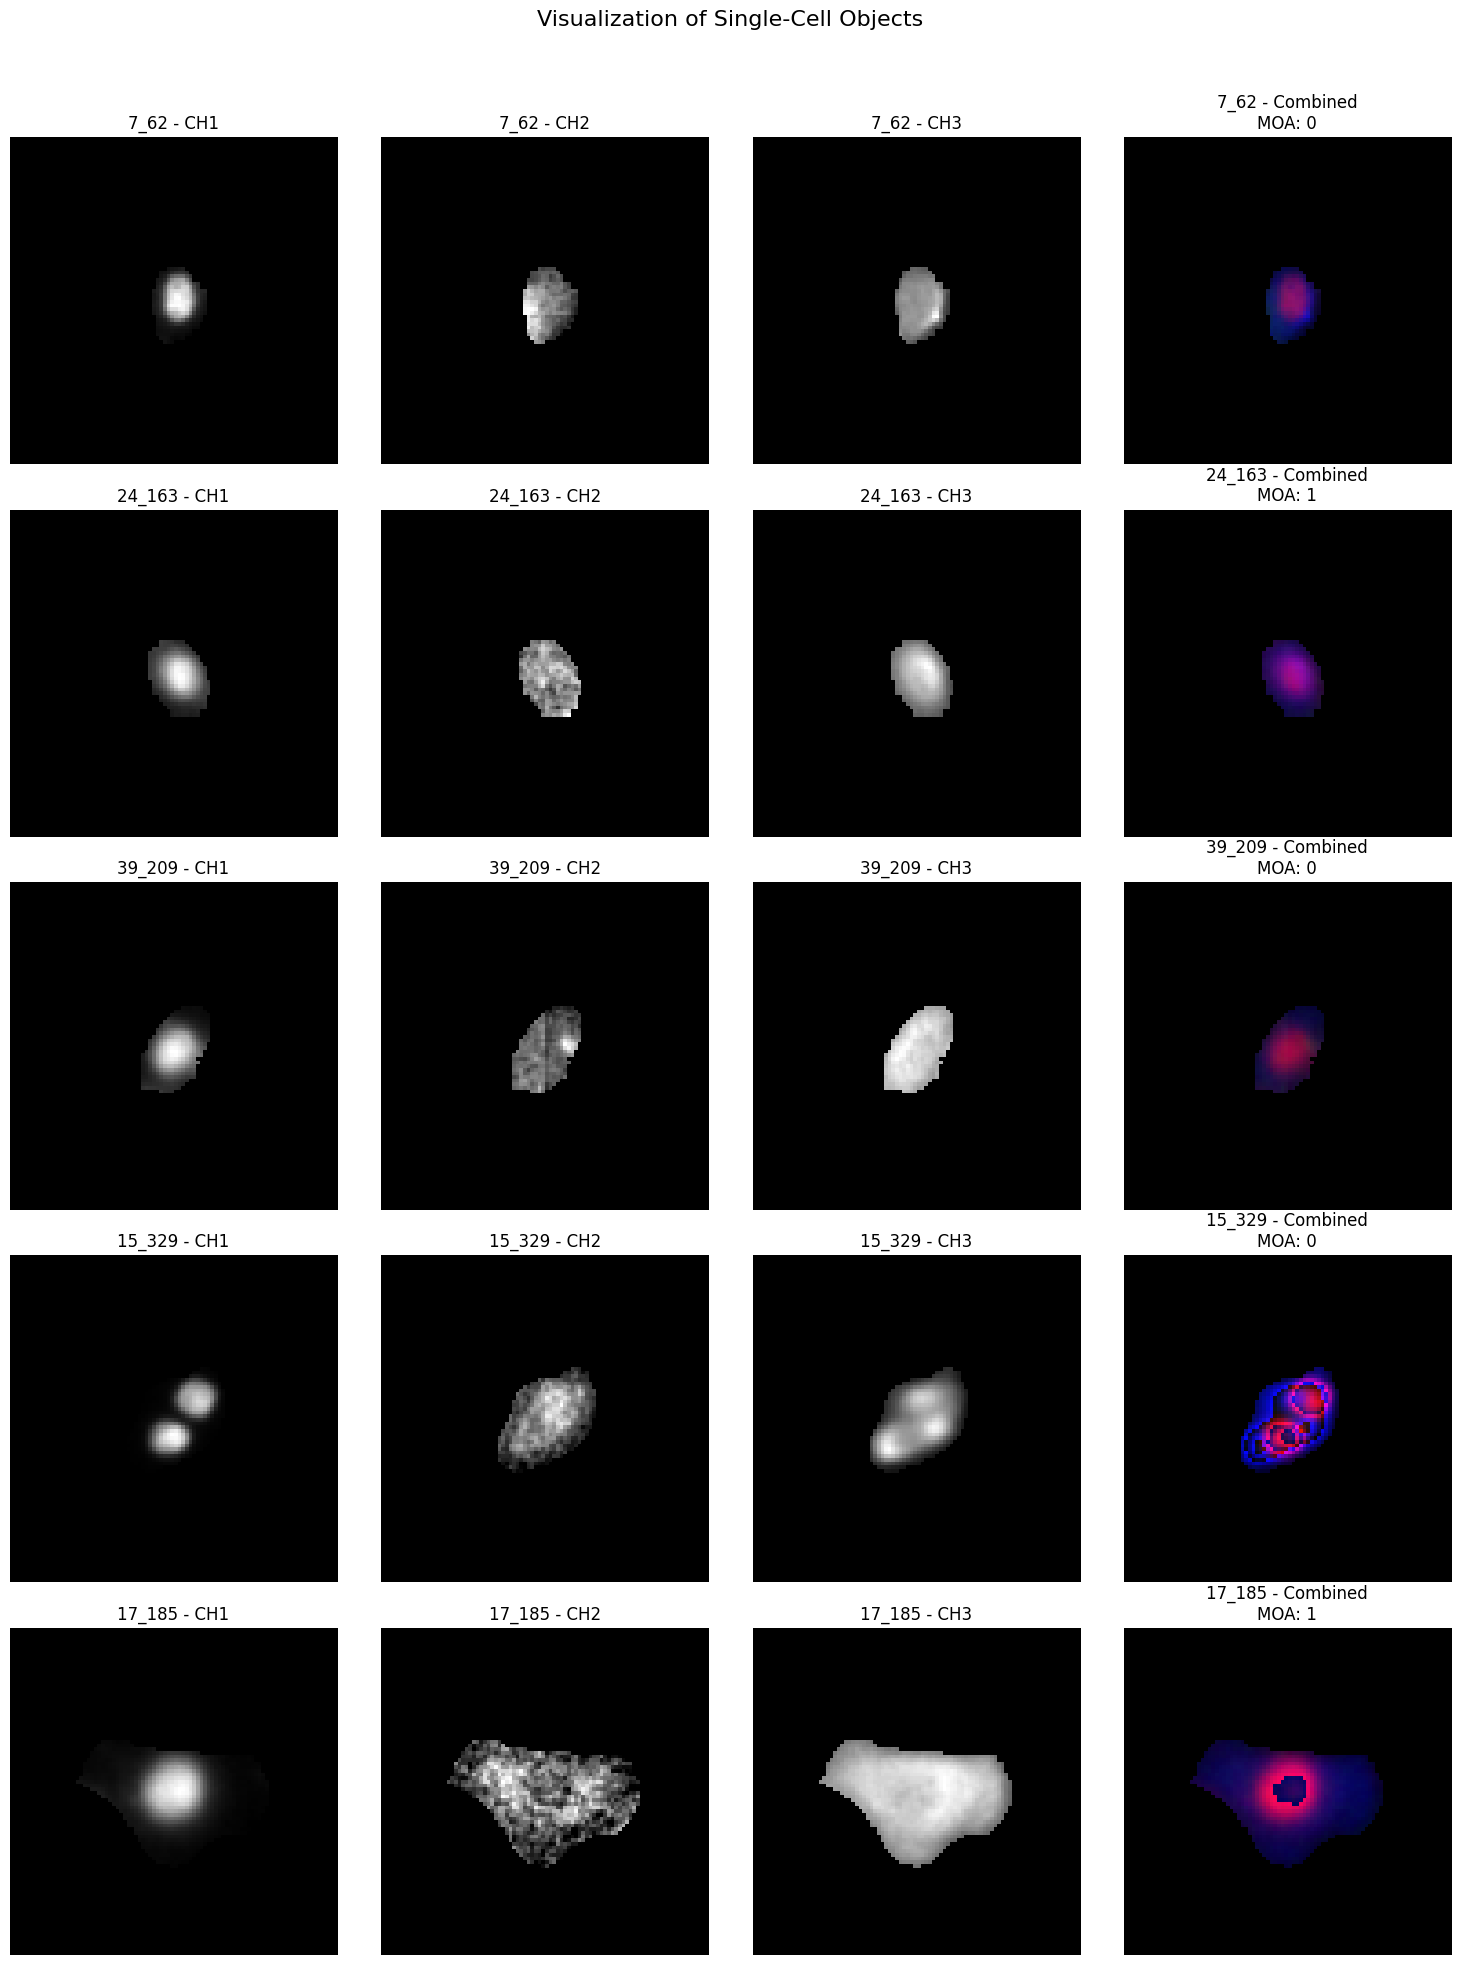

In [54]:
import matplotlib.pyplot as plt

def visualize_single_cells(df, num_samples=5):
    """
    Visualizes a few single-cell objects along with their masks and processed channels.
    """
    # Randomly select a few rows from the dataframe
    samples = df.sample(n=num_samples, random_state=42)
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(15, num_samples * 4))
    fig.suptitle("Visualization of Single-Cell Objects", fontsize=16)
    
    for i, (_, row) in enumerate(samples.iterrows()):
        # Extract data
        bbox = row['Bbox']  # The processed 90x90x3 bounding box
        image_no_bbox = row['ImageNo_BboxNo']
        moa_label = row['MOA_Label']
        
        # Extract each channel from the bounding box
        ch1 = bbox[:, :, 0]
        ch2 = bbox[:, :, 1]
        ch3 = bbox[:, :, 2]

        # Plot original mask and channels
        axes[i, 0].imshow(ch1, cmap='gray')
        axes[i, 0].set_title(f"{image_no_bbox} - CH1")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(ch2, cmap='gray')
        axes[i, 1].set_title(f"{image_no_bbox} - CH2")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(ch3, cmap='gray')
        axes[i, 2].set_title(f"{image_no_bbox} - CH3")
        axes[i, 2].axis('off')
        
        # Plot the combined image
        combined = np.stack([ch1, ch2, ch3], axis=-1).astype('uint8')
        axes[i, 3].imshow(combined)
        axes[i, 3].set_title(f"{image_no_bbox} - Combined\nMOA: {moa_label}")
        axes[i, 3].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Visualize 5 random single-cell objects from the train dataframe
visualize_single_cells(val_df, num_samples=5)


In [55]:
# Load the DataFrames
train_df = pd.read_pickle("train_single_cells_binary.pkl")
val_df = pd.read_pickle("val_single_cells_binary.pkl")
test_df = pd.read_pickle("test_single_cells_binary.pkl")


data_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
print(f"Combined dataset size: {len(data_df)}")


# Define the stratified split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# First split: Train vs. (Val + Test)
train_data, temp_data = train_test_split(data_df, test_size=(val_ratio + test_ratio), stratify=data_df['MOA_Label'], 
                                         random_state=42)

# Second split: Val vs. Test
val_data, test_data = train_test_split(temp_data, test_size=(test_ratio / (val_ratio + test_ratio)), 
                                       stratify=temp_data['MOA_Label'], random_state=42)

print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")


# Compute class weights based on the Y labels
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_data['MOA_Label']), y=train_data['MOA_Label'])

# Map the class weights to a dictionary
class_weight_dict = dict(zip(np.unique(train_data['MOA_Label']), class_weights))
print("Class weights:", class_weight_dict)


Combined dataset size: 111301
Train size: 77910, Validation size: 16695, Test size: 16696
Class weights: {0: 1.7253521126760563, 1: 0.7040229885057471}


In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def scale_to_255(image):
    """Scale an image's pixel values to the range [0, 255]."""
    min_val = np.min(image)
    max_val = np.max(image)
    if max_val > min_val:  # Avoid division by zero for constant images
        scaled_image = 255 * (image - min_val) / (max_val - min_val)
    else:
        scaled_image = np.zeros_like(image)
    return scaled_image


class DataGenerator(Sequence):
    def __init__(self, dataframe, batch_size=16, shuffle=True, class_weights=None, augment=False):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.class_weights = class_weights
        self.indices = np.arange(len(dataframe))
        self.augment = augment

        # Define data augmentation pipeline
        self.datagen = ImageDataGenerator(
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2)
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.dataframe.iloc[batch_indices]

        # Stack images and labels
        X = np.stack(batch_data['Bbox'].values)  # Shape: (batch_size, 90, 90, 3)
        y = batch_data['MOA_Label'].values      # Shape: (batch_size,)


        # Preprocess for EfficientNet
        X = preprocess_input(X)


        # Apply data augmentation if enabled
        if self.augment:
            augmented_X = np.zeros_like(X)
            for i, img in enumerate(X):
                augmented_X[i] = self.datagen.random_transform(img)
            X = augmented_X

        # Sample weights
        if self.class_weights is not None:
            sample_weights = np.array([self.class_weights[label] for label in y])
        else:
            sample_weights = np.ones_like(y, dtype='float32')

        return X, y, sample_weights

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


# Custom Loss Function with Class Weights
def weighted_custom_loss(y_true, y_pred, class_weights):
    """
    Custom loss function with class weights.
    """
    # Convert class_weights to a TensorFlow constant
    class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)

    # Gather the weights for the true labels
    sample_weights = tf.gather(class_weights_tensor, tf.cast(y_true, tf.int32))

    # Compute sparse categorical crossentropy loss
    sce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

    # Weight the loss
    weighted_loss = sce_loss * sample_weights

    return tf.reduce_mean(weighted_loss)  # Average loss over the batch


In [ ]:
# Initialize Data Generators
batch_size = 32
# Training generator with augmentation
train_generator = DataGenerator(train_data, batch_size=batch_size, class_weights=class_weight_dict, augment=True)

# Validation and test generators without augmentation
val_generator = DataGenerator(val_data, batch_size=batch_size, augment=False)
test_generator = DataGenerator(test_data, batch_size=batch_size, shuffle=False, augment=False)

# Define the EfficientNetB0 Model
drop = 0.5
num_classes = len(train_data['MOA_Label'].unique())

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(90, 90, 3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(drop)(x)
#x = layers.BatchNormalization()(x)  # Added Batch Normalization
preds = layers.Dense(num_classes, activation='softmax',
                     kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-2),
                     bias_regularizer=regularizers.L2(1e-2),
                     activity_regularizer=regularizers.L2(1e-3))(x)
cnn_model = models.Model(inputs=base_model.input, outputs=preds)

'''
# Freeze all layers up to layer 180
for layer in base_model.layers[:180]:
    layer.trainable = False

# Unfreeze layers from 180 onwards
for layer in base_model.layers[180:]:
    layer.trainable = True
'''

# Compile the Model
#cnn_model.compile(
    #optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001),
    #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

class_weight_list = [class_weight_dict[i] for i in range(len(class_weight_dict))]

# Compile the Model
cnn_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001),
        loss=lambda y_true, y_pred: weighted_custom_loss(y_true, y_pred, class_weight_list), metrics=['accuracy'])

# Define Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-7)

history = cnn_model.fit(train_generator, validation_data=val_generator, epochs=200, callbacks=[reduce_lr], verbose=2)


2024-11-24 10:39:37.448890: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9497 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5
/home/gauss/miniconda3/envs/tf24/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200


I0000 00:00:1732441213.425104 2299894 service.cc:145] XLA service 0x754adc0025b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732441213.425170 2299894 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-11-24 10:40:14.870362: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-24 10:40:18.992840: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1732441270.801242 2299894 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2435/2435 - 445s - 183ms/step - accuracy: 0.4921 - loss: 0.8543 - val_accuracy: 0.4427 - val_loss: 1.0845 - learning_rate: 1.0000e-04
Epoch 2/200
2435/2435 - 289s - 118ms/step - accuracy: 0.4795 - loss: 0.7727 - val_accuracy: 0.3520 - val_loss: 0.7974 - learning_rate: 1.0000e-04
Epoch 3/200
2435/2435 - 290s - 119ms/step - accuracy: 0.4756 - loss: 0.7347 - val_accuracy: 0.5326 - val_loss: 0.7563 - learning_rate: 1.0000e-04
Epoch 4/200
2435/2435 - 289s - 119ms/step - accuracy: 0.4870 - loss: 0.7194 - val_accuracy: 0.5553 - val_loss: 0.7118 - learning_rate: 1.0000e-04
Epoch 5/200
2435/2435 - 291s - 119ms/step - accuracy: 0.5189 - loss: 0.7141 - val_accuracy: 0.4736 - val_loss: 0.7114 - learning_rate: 1.0000e-04
Epoch 6/200
2435/2435 - 289s - 119ms/step - accuracy: 0.5322 - loss: 0.7128 - val_accuracy: 0.5581 - val_loss: 0.7090 - learning_rate: 1.0000e-04
Epoch 7/200
2435/2435 - 287s - 118ms/step - accuracy: 0.5243 - loss: 0.7120 - val_accuracy: 0.3760 - val_loss: 0.7112 - learning_rate: 1

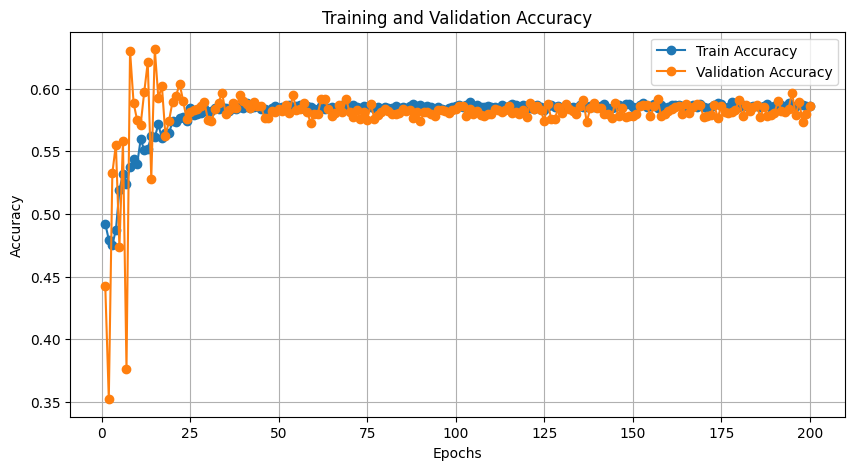

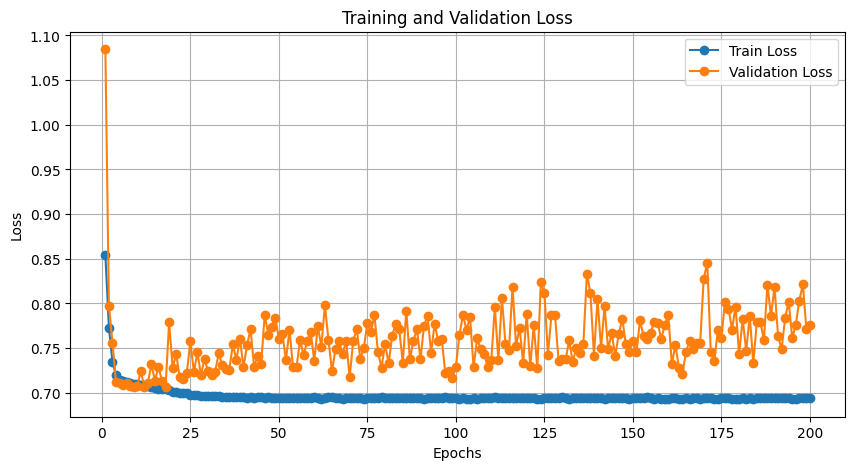

In [61]:
# Extract values from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Evaluate on Test Data
test_loss, test_accuracy = cnn_model.evaluate(test_generator, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

In [ ]:
cnn_model.save('/home/gauss/Documents/Project 1 Image Data MoA Prediction /Revised_Codes/EfficientNetB0_trained_binary_MHB.h5')


In [63]:
# Load without compiling
model = load_model(
    'EfficientNetB0_trained_binary_MHB.h5',
    custom_objects={
        'weighted_custom_loss': lambda y_true, y_pred: weighted_custom_loss(y_true, y_pred, class_weights_list)
    },
    compile=False  # Avoid attempting to compile with the custom loss
)


In [64]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 90, 90, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 90, 90, 3) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 90, 90, 3) │          7 │ rescaling[0][0]   │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 90, 90, 3) │          0 │ normalization[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 91, 91, 3) │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 45, 45,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 45, 45,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 45, 45,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 45, 45,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 45, 45,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 45, 45,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 45, 45,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 45, 45,    │        512 │ block1a_se_excit

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 4,010,110 (15.30 MB)

 Non-trainable params: 42,023 (164.16 KB)